In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
import operator
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
target = 'redemption_status'

features = ['age_range', 'c_coverage_brand', 'c_coverage_brandt', 'c_coverage_category', 'c_coverage_item', 'c_freq_brand', 'c_freq_brandt', 'c_freq_category', 'c_items_freq_brand', 'c_items_freq_brandt', 'c_items_freq_category', 'c_items_rare_brand', 'c_items_rare_brandt', 'c_items_rare_category', 'c_rare_brand', 'c_rare_brandt', 'c_rare_category', 'c_unique_brand', 'c_unique_brandt', 'c_unique_category', 'c_unique_items', 'campaign_id', 'campaign_type', 'coupon_id', 'customer_id', 'duration', 'family_size', 'income_bracket', 'marital_status', 'no_of_children', 'overall_coupon_bprice', 'overall_coupon_bprice_pq', 'overall_coupon_coverage_brand', 'overall_coupon_coverage_brandt', 'overall_coupon_coverage_category', 'overall_coupon_coverage_item', 'overall_coupon_freq_brand', 'overall_coupon_freq_brandt', 'overall_coupon_freq_category', 'overall_coupon_items_freq_brand', 'overall_coupon_items_freq_brandt', 'overall_coupon_items_freq_category', 'overall_coupon_items_p_freq_brand', 'overall_coupon_items_p_freq_brandt', 'overall_coupon_items_p_freq_category', 'overall_coupon_items_p_rare_brand', 'overall_coupon_items_p_rare_brandt', 'overall_coupon_items_p_rare_category', 'overall_coupon_items_rare_brand', 'overall_coupon_items_rare_brandt', 'overall_coupon_items_rare_category', 'overall_coupon_pcdiscount', 'overall_coupon_podiscount', 'overall_coupon_podiscount_pq', 'overall_coupon_ptdiscount', 'overall_coupon_ptdiscount_pq', 'overall_coupon_rare_brand', 'overall_coupon_rare_brandt', 'overall_coupon_rare_category', 'overall_coupon_sprice', 'overall_coupon_sprice_pq', 'overall_coupon_unique_brand', 'overall_coupon_unique_brandt', 'overall_coupon_unique_category', 'overall_coupon_unique_items', 'overall_redemption_ratio', 'range_bprice', 'range_bprice_pq', 'range_coupon_bprice', 'range_coupon_bprice_pq', 'range_coupon_coverage_brand', 'range_coupon_coverage_brandt', 'range_coupon_coverage_category', 'range_coupon_coverage_item', 'range_coupon_freq_brand', 'range_coupon_freq_brandt', 'range_coupon_freq_category', 'range_coupon_items_freq_brand', 'range_coupon_items_freq_brandt', 'range_coupon_items_freq_category', 'range_coupon_items_p_freq_brand', 'range_coupon_items_p_freq_brandt', 'range_coupon_items_p_freq_category', 'range_coupon_items_p_rare_brand', 'range_coupon_items_p_rare_brandt', 'range_coupon_items_p_rare_category', 'range_coupon_items_rare_brand', 'range_coupon_items_rare_brandt', 'range_coupon_items_rare_category', 'range_coupon_pcdiscount', 'range_coupon_pcdiscount_pq', 'range_coupon_podiscount', 'range_coupon_podiscount_pq', 'range_coupon_ptdiscount', 'range_coupon_ptdiscount_pq', 'range_coupon_rare_brand', 'range_coupon_rare_brandt', 'range_coupon_rare_category', 'range_coupon_sprice', 'range_coupon_sprice_pq', 'range_coupon_unique_brand', 'range_coupon_unique_brandt', 'range_coupon_unique_category', 'range_coupon_unique_items', 'range_coverage_brand', 'range_coverage_brandt', 'range_coverage_category', 'range_coverage_item', 'range_freq_brand', 'range_freq_brandt', 'range_freq_category', 'range_items_freq_brand', 'range_items_freq_brandt', 'range_items_freq_category', 'range_items_p_freq_brand', 'range_items_p_freq_brandt', 'range_items_p_freq_category', 'range_items_p_rare_brand', 'range_items_p_rare_brandt', 'range_items_p_rare_category', 'range_items_rare_brand', 'range_items_rare_brandt', 'range_items_rare_category', 'range_pcdiscount', 'range_pcdiscount_pq', 'range_podiscount', 'range_podiscount_pq', 'range_ptdiscount', 'range_ptdiscount_pq', 'range_rare_brand', 'range_rare_brandt', 'range_rare_category', 'range_sprice', 'range_sprice_pq', 'range_unique_brand', 'range_unique_brandt', 'range_unique_category', 'range_unique_items', 'redemption_ratio', 'rented', 'diff_overall_unique_items', 'diff_range_unique_items', 'diff_coupon_unique_items', 'diff_p_overall_unique_items', 'diff_p_range_unique_items', 'diff_p_coupon_unique_items', 'diff_overall_sprice', 'diff_range_sprice', 'diff_coupon_sprice', 'diff_p_overall_sprice', 'diff_p_range_sprice', 'diff_p_coupon_sprice', 'diff_overall_bprice', 'diff_range_bprice', 'diff_coupon_bprice', 'diff_p_overall_bprice', 'diff_p_range_bprice', 'diff_p_coupon_bprice', 'overall_unique_items', 'overall_sprice', 'overall_bprice', 'overall_sprice_pq', 'overall_bprice_pq', 'overall_unique_brand', 'overall_freq_brand', 'overall_rare_brand', 'overall_items_freq_brand', 'overall_items_rare_brand', 'overall_unique_brandt', 'overall_freq_brandt', 'overall_rare_brandt', 'overall_items_freq_brandt', 'overall_items_rare_brandt', 'overall_unique_category', 'overall_freq_category', 'overall_rare_category', 'overall_items_freq_category', 'overall_items_rare_category', 'overall_coverage_item', 'overall_coverage_brand', 'overall_coverage_brandt', 'overall_coverage_category', 'overall_podiscount', 'overall_ptdiscount', 'overall_podiscount_pq', 'overall_pcdiscount_pq', 'overall_ptdiscount_pq', 'diff_overall_podiscount', 'diff_range_podiscount', 'diff_coupon_podiscount', 'diff_overall_pcdiscount', 'diff_range_pcdiscount', 'diff_coupon_pcdiscount', 'diff_overall_ptdiscount', 'diff_range_ptdiscount', 'diff_coupon_ptdiscount', 'diff_overall_sprice_pq', 'diff_range_sprice_pq', 'diff_coupon_sprice_pq', 'diff_p_overall_sprice_pq', 'diff_p_range_sprice_pq', 'diff_p_coupon_sprice_pq', 'diff_overall_bprice_pq', 'diff_range_bprice_pq', 'diff_coupon_bprice_pq', 'diff_p_overall_bprice_pq', 'diff_p_range_bprice_pq', 'diff_p_coupon_bprice_pq', 'diff_overall_podiscount_pq', 'diff_range_podiscount_pq', 'diff_coupon_podiscount_pq', 'diff_overall_pcdiscount_pq', 'diff_range_pcdiscount_pq', 'diff_coupon_pcdiscount_pq', 'diff_overall_ptdiscount_pq', 'diff_range_ptdiscount_pq', 'diff_coupon_ptdiscount_pq', 'diff_overall_unique_brand', 'diff_range_unique_brand', 'diff_coupon_unique_brand', 'diff_p_overall_unique_brand', 'diff_p_range_unique_brand', 'diff_p_coupon_unique_brand', 'diff_overall_unique_brandt', 'diff_range_unique_brandt', 'diff_coupon_unique_brandt', 'diff_p_overall_unique_brandt', 'diff_p_range_unique_brandt', 'diff_p_coupon_unique_brandt', 'diff_overall_unique_category', 'diff_range_unique_category', 'diff_coupon_unique_category', 'diff_p_overall_unique_category', 'diff_p_range_unique_category', 'diff_p_coupon_unique_category', 'diff_overall_coverage_brand', 'diff_range_coverage_brand', 'diff_coupon_coverage_brand', 'diff_p_overall_coverage_brand', 'diff_p_range_coverage_brand', 'diff_p_coupon_coverage_brand', 'diff_overall_coverage_category', 'diff_range_coverage_category', 'diff_coupon_coverage_category', 'diff_p_overall_coverage_category', 'diff_p_range_coverage_category', 'diff_p_coupon_coverage_category', 'c_diff_unique_items', 'c_diff_unique_brand', 'c_diff_unique_brandt', 'c_diff_unique_category', 'c_diff_coverage_item', 'c_diff_coverage_brand', 'c_diff_coverage_brandt', 'c_diff_coverage_category', 'match_freq_brand', 'match_rare_brand', 'match_freq_brandt', 'match_rare_brandt', 'match_freq_category', 'match_rare_category']

categorical_columns = ['age_range', 'c_freq_brand', 'c_freq_brandt', 'c_freq_category', 'c_rare_brand', 'c_rare_brandt', 'c_rare_category', 'campaign_id', 'campaign_type', 'coupon_id', 'customer_id', 'family_size', 'income_bracket', 'marital_status', 'no_of_children', 'overall_coupon_freq_brand', 'overall_coupon_freq_brandt', 'overall_coupon_freq_category', 'overall_coupon_rare_brand', 'overall_coupon_rare_brandt', 'overall_coupon_rare_category', 'range_coupon_freq_brand', 'range_coupon_freq_brandt', 'range_coupon_freq_category', 'range_coupon_rare_brand', 'range_coupon_rare_brandt', 'range_coupon_rare_category', 'range_freq_brand', 'range_freq_brandt', 'range_freq_category', 'range_rare_brand', 'range_rare_brandt', 'range_rare_category', 'rented', 'overall_freq_brand', 'overall_rare_brand', 'overall_freq_brandt', 'overall_rare_brandt', 'overall_freq_category', 'overall_rare_category', 'match_freq_brand', 'match_rare_brand', 'match_freq_brandt', 'match_rare_brandt', 'match_freq_category', 'match_rare_category']

In [3]:
def preprocess(trainset, testset):        
    dataset = trainset.append(testset, sort=False).fillna(0)
    
    for column in categorical_columns:
        dataset[column] = dataset[column].astype('category')
    
    dataset = dataset[features]
#     dataset = pd.get_dummies(dataset[features])
#     dataset = dataset.drop(encoded_columns, axis=1)
    
    trainset = trainset[[target]].join(dataset)
    testset = testset[[]].join(dataset)
    
    return trainset, testset

In [4]:
trainset = pd.read_csv('data/train/train_feature.csv', index_col='id', parse_dates=['start_date','end_date'])
trainset.head()

,redemption_status,age_range,c_coverage_brand,c_coverage_brandt,c_coverage_category,c_coverage_item,c_freq_brand,c_freq_brandt,c_freq_category,c_items_freq_brand,...,c_diff_coverage_item,c_diff_coverage_brand,c_diff_coverage_brandt,c_diff_coverage_category,match_freq_brand,match_rare_brand,match_freq_brandt,match_rare_brandt,match_freq_category,match_rare_category
id,,,,,,,,,,,,,,,,,,,,,
1,0,46-55,0.000362,0.5,0.052632,0.001688,1105,1,Grocery,64,...,0.001688,0.000362,0.5,0.052632,0,0,0,0,0,0
2,0,36-45,0.000181,0.5,0.052632,0.000041,56,0,Grocery,3,...,0.000041,0.000181,0.5,0.052632,0,0,0,0,0,0
6,0,46-55,0.000181,0.5,0.052632,0.000905,560,1,Pharmaceutical,67,...,0.000905,0.000181,0.5,0.052632,0,0,0,0,0,0
7,0,NaN,0.000181,0.5,0.052632,0.000054,611,1,Grocery,4,...,0.000054,0.000181,0.5,0.052632,0,0,0,0,0,0
9,0,46-55,0.000181,0.5,0.052632,0.000432,1558,1,Grocery,32,...,0.000432,0.000181,0.5,0.052632,0,0,0,0,0,0


In [5]:
testset = pd.read_csv('data/test/test_feature.csv', index_col='id', parse_dates=['start_date','end_date'])
testset.head()

,age_range,c_coverage_brand,c_coverage_brandt,c_coverage_category,c_coverage_item,c_freq_brand,c_freq_brandt,c_freq_category,c_items_freq_brand,c_items_freq_brandt,...,c_diff_coverage_item,c_diff_coverage_brand,c_diff_coverage_brandt,c_diff_coverage_category,match_freq_brand,match_rare_brand,match_freq_brandt,match_rare_brandt,match_freq_category,match_rare_category
id,,,,,,,,,,,,,,,,,,,,,
3,36-45,0.000181,0.5,0.052632,0.000972,1075,1,Grocery,72,72,...,0.000945,0.000000,0.0,0.000000,1,1,1,1,1,1
4,26-35,0.000543,0.5,0.052632,0.000446,57,1,Pharmaceutical,26,33,...,0.000419,0.000362,0.0,0.000000,1,0,1,1,1,1
5,26-35,0.000181,0.5,0.052632,0.000257,1335,1,Grocery,19,19,...,0.000257,0.000181,0.5,0.052632,0,0,0,0,0,0
8,18-25,0.000181,0.5,0.052632,0.000999,1996,1,Grocery,74,74,...,0.000999,0.000181,0.5,0.052632,0,0,0,0,0,0
10,NaN,0.000181,0.5,0.052632,0.000243,209,1,Grocery,18,18,...,0.000243,0.000181,0.5,0.052632,0,0,0,0,0,0


In [6]:
val2_ids = trainset[trainset.campaign_id > 25].index
sub_trainset = trainset[trainset.campaign_id < 26]

train_ids = []
val1_ids = []
for campaign in sub_trainset.campaign_id.unique():
    train, val = train_test_split(trainset[trainset.campaign_id == campaign].index, test_size=0.2, random_state=41)
    train_ids.extend(train)
    val1_ids.extend(val)
len(train_ids), len(val1_ids), len(val2_ids)

(48916, 12235, 17218)

In [7]:
trainset, testset = preprocess(trainset, testset)

print("Trainset size: {}".format(trainset.shape))
print("Testset size: {}".format(testset.shape))

Trainset size: (78369, 262)
Testset size: (50226, 261)


In [8]:
feature_columns = features
# trainset, validationset = train_test_split(trainset, test_size=0.3)

val1set = trainset.loc[val1_ids]
val2set = trainset.loc[val2_ids]
trainset = trainset.loc[train_ids]
val1set.shape, val2set.shape, trainset.shape

((12235, 262), (17218, 262), (48916, 262))

In [9]:
def train(features, verbose=False):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "boosting": "gbdt",
        "verbosity" : -1,
        "seed": 41,
        "learning_rate": 0.08, # Try small values
#         "num_leaves": 25,
#         "max_depth": 6, # Try max_depth to avoid growing deep tree
#         "min_data_in_leaf": 20,
        "pos_bagging_fraction": 1.0,
        "neg_bagging_fraction": 0.09,
        "bagging_freq": 50,
        "feature_fraction": 0.4,
        "early_stopping_round": 100
    }
    
    X_train, y_train = trainset[features], trainset[target]
    X_val1, y_val1 = val1set[features], val1set[target]
    X_val2, y_val2 = val2set[features], val2set[target]
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_val1, label=y_val1)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], verbose_eval=verbose, evals_result=evals_result)
    score1 = evals_result['valid_0']['auc'][-1]
    
    y_pred = model.predict(X_val2, num_iteration=model.best_iteration)
    score2 = roc_auc_score(y_val2, y_pred)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    score3 = roc_auc_score(y_train, y_pred)
    
    return model, score1, score2, score3

In [10]:
all_model, all_score1, all_score2, all_score3 = train(feature_columns, verbose=100)
all_score1, all_score2, all_score3

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.997316
[200]	valid_0's auc: 0.99746
Early stopping, best iteration is:
[198]	valid_0's auc: 0.997476


(0.9974416602285467, 0.9973907182281336, 0.9999999790554327)

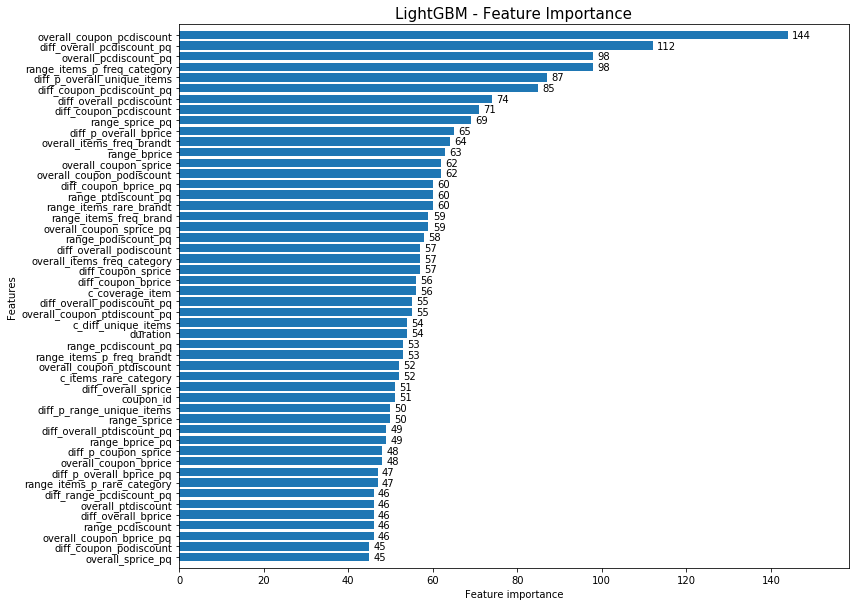

In [11]:
ax = lgb.plot_importance(all_model, max_num_features=50, height=0.8, figsize=(12, 10))
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

Feature Verification

In [12]:
# %%time

# def exclude_feature(features, index):
#     new_features = features[:index] + features[index+1:]
#     model, _, score, _ = train(new_features)
#     return score

# score_map = {}
# for index, name in enumerate(feature_columns):
#     score = exclude_feature(feature_columns, index) - all_score2
#     print("{}: {}".format(name, score))
#     score_map[name] = score

In [13]:
# score_map = sorted(score_map.items(), key=operator.itemgetter(1), reverse=True)
# score_map

In [14]:
X_test = testset[feature_columns]
testset[target] = all_model.predict(X_test, num_iteration=all_model.best_iteration)

submission = testset[[target]]
submission.to_csv('data/report/report_1.csv')